In [1]:
import torch
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

iris = load_iris()
X = iris.data
y = iris.target

indices_0_1 = np.where((y == 0) | (y == 1))[0]
data = X[indices_0_1]
label = y[indices_0_1]

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=0)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [2]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def run(self, x):
        self.out = torch.sigmoid(x)
        return self.out

    def back(self, dout):
        if self.out is None:
            raise RuntimeError("Must call forward before backward")
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [3]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def run(self, x):
        self.x = x
        out = torch.matmul(x, self.W) + self.b
        return out

    def back(self, dout):
        dx = torch.matmul(dout, self.W.T)
        self.dW = torch.matmul(self.x.T, dout)
        self.db = torch.sum(dout, dim=0)
        return dx

In [4]:
import torch.nn.functional as F

class SigmoidWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def run(self, x, t):
        self.t = t
        self.y = torch.sigmoid(x)
        self.loss = F.binary_cross_entropy(self.y, self.t)
        return self.loss

    def back(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx.unsqueeze(1)

In [5]:
from collections import OrderedDict

class IrisNet:
    def __init__(self):
        self.params = {}
        # 调整权重形状：W1 (4,5), W2 (5,5), W3 (5,1)
        self.params['W1'] = torch.randn(4, 5, dtype=torch.float32, requires_grad=False) * 0.1
        self.params['b1'] = torch.randn(5, dtype=torch.float32, requires_grad=False) * 0.1
        self.params['W2'] = torch.randn(5, 5, dtype=torch.float32, requires_grad=False) * 0.1
        self.params['b2'] = torch.randn(5, dtype=torch.float32, requires_grad=False) * 0.1
        self.params['W3'] = torch.randn(5, 1, dtype=torch.float32, requires_grad=False) * 0.1
        self.params['b3'] = torch.randn(1, dtype=torch.float32, requires_grad=False) * 0.1

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Sigmoid2'] = Sigmoid()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SigmoidWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.run(x)
        return x.squeeze()  # 去掉多余的维度，输出形状为 (batch_size,)

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.run(y, t)

    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.lastLayer.back(dout)
        layers = list(self.layers.values())[::-1]  # 反向传播需要逆序
        for layer in layers:
            dout = layer.back(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db
        return grads

    def accuracy(self, x, t):
        y = self.predict(x) > 0.5
        accuracy = torch.sum(y == t).item() / float(x.shape[0])
        return accuracy

In [6]:
%%time
network = IrisNet()

iters_num = 400
learning_rate = 0.5
train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in range(iters_num):
    grad = network.gradient(X_train, y_train)

    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(X_train, y_train)
    train_loss_list.append(loss.item())

    train_acc = network.accuracy(X_train, y_train)
    test_acc = network.accuracy(X_test, y_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    if i % 50 == 0:
        print(f"Epoch {i}, loss: {loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 0, loss: 0.6944, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 50, loss: 0.6930, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 100, loss: 0.6925, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 150, loss: 0.6915, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 200, loss: 0.6879, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 250, loss: 0.6646, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 300, loss: 0.3963, Train Acc: 0.9500, Test Acc: 0.9500
Epoch 350, loss: 0.0936, Train Acc: 1.0000, Test Acc: 1.0000
CPU times: user 45.2 ms, sys: 2.87 ms, total: 48 ms
Wall time: 52.4 ms


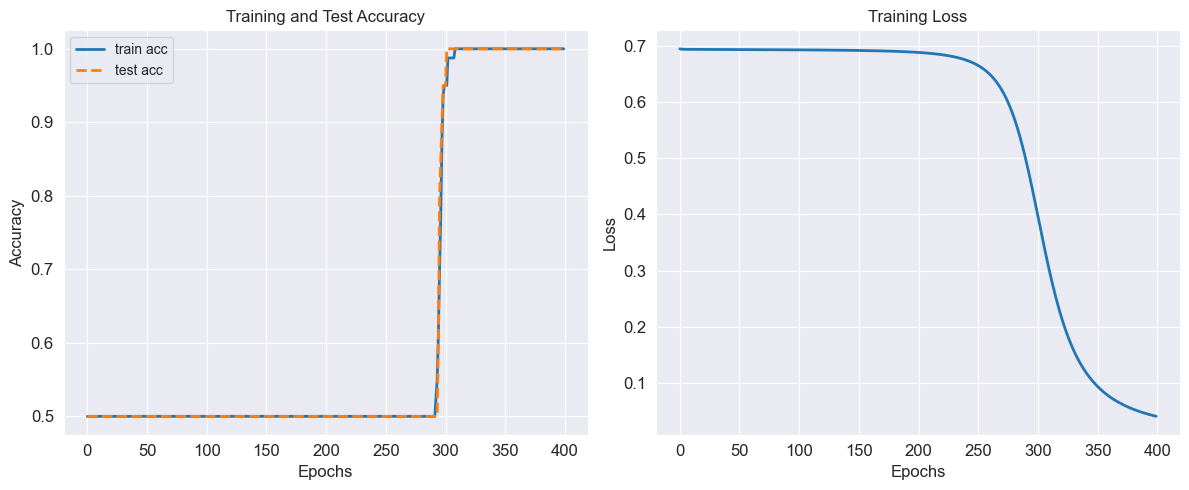

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='train acc', linewidth=2)
plt.plot(test_acc_list, label='test acc', linestyle='--', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Test Accuracy', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='train loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
x1 = torch.tensor(100, dtype=torch.float32)
print(x1)

x = torch.tensor(100.0, requires_grad=True)
print(x)

tensor(100.)
tensor(100., requires_grad=True)


In [9]:
y = x * 2
print(y)

tensor(200., grad_fn=<MulBackward0>)


In [10]:
print(x.grad_fn)
print(y.grad_fn)

None


In [11]:
z = y * 1.1
print(z)

tensor(220., grad_fn=<MulBackward0>)


In [12]:
z.backward()
print(x.grad)

tensor(2.2000)


In [13]:
x1 = torch.tensor(100, dtype=torch.float32)
out = x1 * 2 * 1.1
print(x1.requires_grad)
print(out.grad_fn)

x1.requires_grad_(True)
out1 = x1 * 2 * 1.1
print(x1.requires_grad)
print(out1.grad_fn)

False
None
True


In [14]:
with torch.no_grad():
    print(x1.requires_grad)

True


In [15]:
print((x1 * 2 * 1.1).requires_grad)

with torch.no_grad():
    print((x1 * 2 * 1.1).requires_grad)

True
False


In [16]:
print(x1.requires_grad)
y = x1.detach()
print(x1.requires_grad)
print(x1.eq(y).all())

True
True
tensor(True)


In [17]:
from torch import nn

y = torch.tensor([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0], requires_grad=True)
criterion = nn.CrossEntropyLoss()
loss = criterion(y, torch.tensor(2))
print(loss)
loss.backward()
print(y.grad)

tensor(1.8195, grad_fn=<NllLossBackward0>)
tensor([ 0.0983,  0.0935, -0.8379,  0.0890,  0.0935,  0.0983,  0.0890,  0.0983,
         0.0890,  0.0890])


In [23]:
model = nn.Sequential(
    nn.Linear(4, 10),    
    nn.Sigmoid(),           
    nn.Linear(10, 10),   
    nn.Sigmoid(),
    nn.Linear(10, 3),
)

In [24]:
from torchinfo import summary
summary(model, input_size=(1, 4))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3]                    --
├─Linear: 1-1                            [1, 10]                   50
├─Sigmoid: 1-2                           [1, 10]                   --
├─Linear: 1-3                            [1, 10]                   110
├─Sigmoid: 1-4                           [1, 10]                   --
├─Linear: 1-5                            [1, 3]                    33
Total params: 193
Trainable params: 193
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [25]:
iris = load_iris()
x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.LongTensor(y_train)
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.LongTensor(y_test)

(112, 4) (38, 4) (112,) (38,)


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [30]:
num_epochs = 1000

model.train()
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _, train_predicted = torch.max(outputs.data, 1)
    train_accuracy = (train_predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f},  训练集准确率: {train_accuracy:.4f}')

Epoch [100/1000], Loss: 0.0541,  训练集准确率: 0.9911
Epoch [200/1000], Loss: 0.0510,  训练集准确率: 0.9821
Epoch [300/1000], Loss: 0.0483,  训练集准确率: 0.9821
Epoch [400/1000], Loss: 0.0461,  训练集准确率: 0.9821
Epoch [500/1000], Loss: 0.0443,  训练集准确率: 0.9821
Epoch [600/1000], Loss: 0.0427,  训练集准确率: 0.9821
Epoch [700/1000], Loss: 0.0414,  训练集准确率: 0.9821
Epoch [800/1000], Loss: 0.0403,  训练集准确率: 0.9821
Epoch [900/1000], Loss: 0.0393,  训练集准确率: 0.9821
Epoch [1000/1000], Loss: 0.0385,  训练集准确率: 0.9911


In [31]:
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'测试集准确率: {accuracy:.4f}')

测试集准确率: 0.9474
